In [2]:
import os                           # For file handling
import re                           # For regular expressions
import subprocess                   # For running shell commands
from tabulate import tabulate       # For pretty printing of tables
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt     # For plotting   
import pandas as pd                 # For data manipulation
import seaborn as sns               # For plotting and data visualization

In [3]:
# Compile C files with various optimization levels
def compile_c_files(files, opt_lvls):
    for f in files:
        print(f"Compiling {f}")
        for o in opt_lvls:
            print(f"\tUsing Optimization Level: {o}")
            exe = f.split('.')[0] + "." + o.replace('-', '')
            try:
                subprocess.run(["gcc-13", f, "-o", exe, o, "-fopenmp"], check=True) # Change gcc-13 to gcc if you are using a different version!!
            except subprocess.CalledProcessError as e:
                print(f"Error during compilation of {f} with optimization {o}: {e}")

def execute_benchmarks(files, opt_lvls, num_threads, run_number):
    benchmarks = []
    with open('execution_times.txt', 'a') as file:
        for f in files:
            for o in opt_lvls:
                for nc in range(1, num_threads + 1):
                    exe = "./" + f.split('.')[0] + "." + o.replace('-', '')
                    print(f"Running {exe} using {nc} Cores")
                    env = os.environ.copy()
                    env["OMP_NUM_THREADS"] = str(nc)
                    try:
                        result = subprocess.check_output([exe], env=env)
                        result_str = result.decode("utf-8")
                        time = result_str.split(' ')[3]
                        print(f"\tTime taken {time} sec")
                        benchmarks.append((run_number, f, o, nc, f"{time} sec"))
                        file.write(f"{run_number}, {f}, {o}, {nc}, {time} sec\n")
                    except subprocess.CalledProcessError as e:
                        print(f"Error during execution of {exe} with {nc} cores: {e}")
    print(tabulate(benchmarks, headers=["Run", "FileName", "Optimization Level", "Number of Threads", "Time"], tablefmt="simple"))

def run_tests_with_optimization_levels(total_runs, num_threads):
    all_files = os.listdir(".")
    pattern = re.compile(".+\.c$")
    files = [file for file in all_files if pattern.match(file)]
    opt_lvls = ["-O0", "-O1", "-O2", "-O3", "-Ofast", "-Os"]

    print(f"Running Tests for Files: {files}")
    for run_number in range(1, total_runs + 1):
        print(f"Starting Run {run_number}")
        compile_c_files(files, opt_lvls)
        execute_benchmarks(files, opt_lvls, num_threads, run_number)

In [3]:
# Run the tests
run_tests_with_optimization_levels(5, 12)

Running Tests for Files: ['slow.c', 'fast.c', 'medium.c']
Starting Run 1
Compiling slow.c
	Using Optimization Level: -O0
	Using Optimization Level: -O1
	Using Optimization Level: -O2
	Using Optimization Level: -O3
	Using Optimization Level: -Ofast
	Using Optimization Level: -Os
Compiling fast.c
	Using Optimization Level: -O0
	Using Optimization Level: -O1
	Using Optimization Level: -O2
	Using Optimization Level: -O3
	Using Optimization Level: -Ofast
	Using Optimization Level: -Os
Compiling medium.c
	Using Optimization Level: -O0
	Using Optimization Level: -O1
	Using Optimization Level: -O2
	Using Optimization Level: -O3
	Using Optimization Level: -Ofast
	Using Optimization Level: -Os
Running ./slow.O0 using 1 Cores
	Time taken 0.6000 sec
Running ./slow.O0 using 2 Cores
	Time taken 1.0456 sec
Running ./slow.O0 using 3 Cores
	Time taken 7.6383 sec
Running ./slow.O0 using 4 Cores
	Time taken 1.5635 sec
Running ./slow.O0 using 5 Cores
	Time taken 1.3303 sec
Running ./slow.O0 using 6 Cores


In [5]:
# Read the data from the file
file_path = 'execution_times.txt'
data = pd.read_csv(file_path, names=['Run', 'FileName', 'OptimizationLevel', 'NumThreads', 'TimeSec'], header=None)
data['TimeSec'] = data['TimeSec'].str.replace(' sec', '').astype(float)

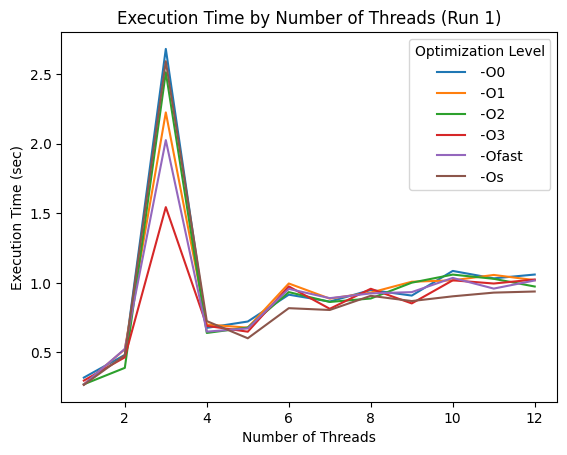

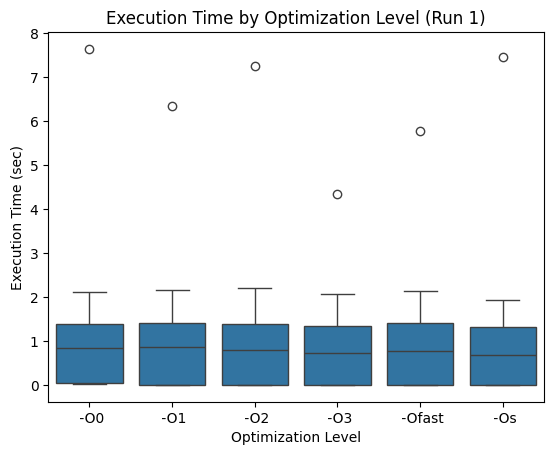

In [6]:
# Specific run data for analysis
specific_run_data = data[data['Run'] == 1]

# Execution time by number of threads for a specific run
sns.lineplot(x='NumThreads', y='TimeSec', hue='OptimizationLevel', data=specific_run_data, errorbar=None)
plt.title('Execution Time by Number of Threads (Run 1)')
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (sec)')
plt.legend(title='Optimization Level')
plt.show()

# Execution time by optimization level for a specific run
sns.boxplot(x='OptimizationLevel', y='TimeSec', data=specific_run_data)
plt.title('Execution Time by Optimization Level (Run 1)')
plt.xlabel('Optimization Level')
plt.ylabel('Execution Time (sec)')

plt.show()


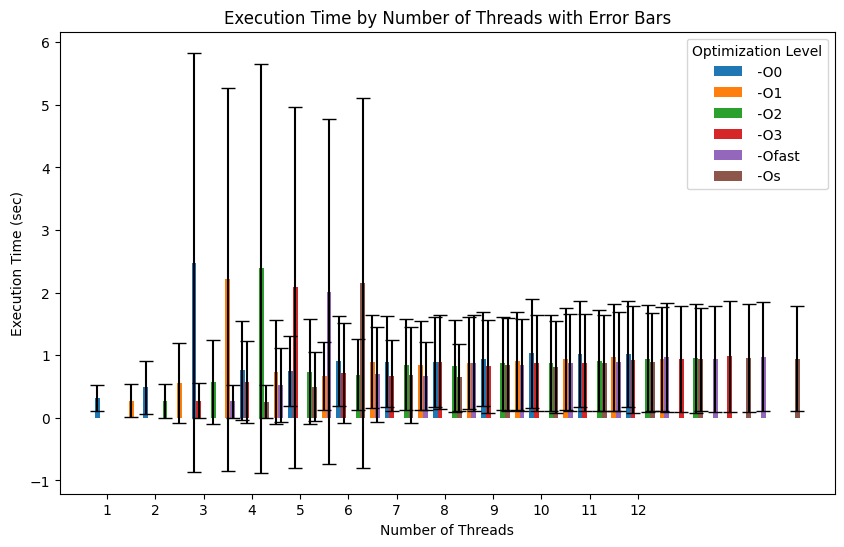

In [7]:
# Calculate mean, std, min, and max for each group
stability_stats = data.groupby(['FileName', 'OptimizationLevel', 'NumThreads']).agg(['mean', 'std', 'min', 'max'])

# Assuming `stability_stats` is prepared with mean and std calculations
stability_stats = data.groupby(['OptimizationLevel', 'NumThreads']).agg(MeanTimeSec=('TimeSec', 'mean'), StdTimeSec=('TimeSec', 'std')).reset_index()

# Unique optimization levels and thread counts for plotting
optimization_levels = stability_stats['OptimizationLevel'].unique()
thread_counts = stability_stats['NumThreads'].unique()

# Prepare figure and axes for subplotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, opt_lvl in enumerate(optimization_levels):
    # Filter data for each optimization level
    opt_data = stability_stats[stability_stats['OptimizationLevel'] == opt_lvl]
    
    # X positions for the bars
    x_pos = np.arange(len(thread_counts)) + i*(len(optimization_levels)+1)*0.1
    
    # Plot bars with error bars
    ax.bar(x_pos, opt_data['MeanTimeSec'], yerr=opt_data['StdTimeSec'], width=0.1, label=opt_lvl, capsize=5)

# Set the x-ticks to be the middle of each group of bars
ax.set_xticks(np.arange(len(thread_counts)) + 0.2)
ax.set_xticklabels(thread_counts)

ax.set_xlabel('Number of Threads')
ax.set_ylabel('Execution Time (sec)')
ax.set_title('Execution Time by Number of Threads with Error Bars')
ax.legend(title='Optimization Level')

plt.show()


In [9]:
# Group by NumThreads, OptimizationLevel, and FileName, then find the minimum TimeSec
min_times_by_thread_and_opt = data.groupby(['NumThreads', 'OptimizationLevel', 'FileName']).agg(MinTimeSec=('TimeSec', 'min')).reset_index()

# Filter for 1 and 12 threads
threads_of_interest = [1, 12]
filtered_data = min_times_by_thread_and_opt[min_times_by_thread_and_opt['NumThreads'].isin(threads_of_interest)]

# Now, for each thread count of interest (1 and 12), find the entry with the minimum execution time for each FileName
shortest_times = pd.DataFrame()
for thread in threads_of_interest:
    for file_name in [' fast.c', ' slow.c', ' medium.c']:
        min_time_row = filtered_data[(filtered_data['NumThreads'] == thread) & (filtered_data['FileName'] == file_name)].nsmallest(1, 'MinTimeSec')
        shortest_times = pd.concat([shortest_times, min_time_row], ignore_index=True)

# Display the results, including the optimization level
print(shortest_times)

   NumThreads OptimizationLevel   FileName  MinTimeSec
0           1               -O2     fast.c      0.0000
1           1               -O0     slow.c      0.5884
2           1               -O1   medium.c      0.1553
3          12               -O2     fast.c      0.0002
4          12               -O1     slow.c      1.7597
5          12               -O2   medium.c      0.5154
